<a href="https://colab.research.google.com/github/RakshitTra/Load-Forecasting-using-deep-learning/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric

# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

# load all data
dataset = read_csv('/content/drive/My Drive/dataset/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')



daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('/content/drive/My Drive/dataset/household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16          1209.176025  ...    14680.933594
2006-12-17          3390.459961  ...    36946.667969
2006-12-18          2203.825928  ...    19028.433594
2006-12-19          1666.193970  ...    13131.900391
2006-12-20          2225.748047  ...    20384.800781

[5 rows x 8 columns]


In [2]:
from math import sqrt
from numpy import split
from numpy import array
import numpy as np
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn import preprocessing
# from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
from keras.callbacks import ModelCheckpoint
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
def split_dataset(data):
  # split into standard weeks
  last_year_hour=365*24
  train, test = data[:-last_year_hour], data[-last_year_hour:]
  # restructure into windows of weekly data
  # train = array(split(train, len(train)/7))
  # test = array(split(test, len(test)/7))
  return train, test


In [0]:
def to_supervised(data, n_input, n_out=1):
  # flatten data
  #data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  data=array(data)
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)


In [0]:
def Single_layer_lstm(train_X,train_y):
  model = Sequential()
  model.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dropout(0.2))
  #    model.add(LSTM(70))
  #    model.add(Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  filepath="/content/drive/My Drive/dataset/weights/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]


  # fit network
  history = model.fit(train_X, train_y, epochs=150, batch_size=64,callbacks=callbacks_list, verbose=2, shuffle=False)
  # filepath="/content/drive/My Drive/dataset/weights.best.hdf5"
  # checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  # callbacks_list = [checkpoint]

  plt.plot(history.history['loss'])
  # plt.plot(hitory.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper right')
  plt.show()
  return model


(34421, 168, 8)
(34421, 1)
(25661, 168, 8)
(25661, 1)
(8760, 168, 8)
(8760, 1)
(8760, 1)


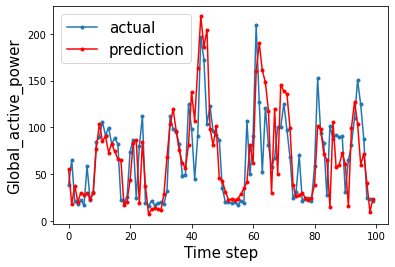

In [16]:
dataset = read_csv('/content/drive/My Drive/dataset/household_power_consumption_hours.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
from numpy import array
# split into train and test
def graph(actual, predicted):
  aa=[x for x in range(100)]
  actual=np.ravel(actual)
  predicted=np.ravel(predicted)
  plt.plot(aa, actual[00:100], marker='.', label="actual")
  plt.plot(aa, predicted[00:100],'r', marker='.', label="prediction")
  plt.ylabel('Global_active_power', size=15)
  plt.xlabel('Time step', size=15)  
  plt.legend(fontsize=15)
  # plt.show()
  plt.savefig("/content/drive/My Drive/dataset/myfig3.png")


x = dataset.values #returns a numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled)

n_input = 7*24
X, Y = to_supervised(dataset.values,n_input)
train_x,test_x=split_dataset(X)
train_y,test_y=split_dataset(Y)
print(X.shape)
print(Y.shape)
# train_y=np.ravel(train_y)#train_y.reshape(train_y.shape[0])
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
# model1=Single_layer_lstm(train_x,train_y)
# model1.save("/content/drive/My Drive/dataset/model200.h5")

# # load model
from keras.models import load_model
# model1.load_weights("/content/drive/My Drive/dataset/weights/weights-improvement-148-0.0033.hdf5")

model1 = load_model('/content/drive/My Drive/dataset/weights/weights-improvement-148-0.0033.hdf5')

yhat = model1.predict(test_x)
test_x = test_x[:,0,:].reshape((test_x.shape[0], 8))

inv_yhat = np.concatenate((yhat, test_x[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
test_y = inv_y[:,0]

print(yhat.shape)
graph(test_y,inv_yhat)
